In [4]:
import anndata as ad
# import os
import re
import numpy as np
import squidpy as sq
import scanpy as sc

import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [5]:
# Nuclear protein average intensity matrix
adata_ave_int = ad.read_h5ad('ave_intensity_matrix.h5ad')

In [6]:
# RNA matrix
adata_RNA = ad.read_h5ad('filtered_RNA_matrix.h5ad')

## Nuclear protein intensity correlation

In [8]:
# 1. Backup original coordinates
original_coords = adata_ave_int.obsm["spatial"].copy()

# 2. Orient spatial coordinates
theta = np.radians(-135)
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
rotated_coords = original_coords @ rotation_matrix.T
adata_ave_int.obsm["spatial_rotated"] = rotated_coords  # store in new obsm

In [9]:
# find center coordinate
x_center = (np.min(rotated_coords[:, 0]) + np.max(rotated_coords[:, 0])) / 2

# Separate into left vs right halves
left_half = rotated_coords[:, 0] <= x_center
right_half = rotated_coords[:, 0] > x_center

# Assgin cells in obs
adata_ave_int.obs["half"] = np.where(right_half, "right", "left")

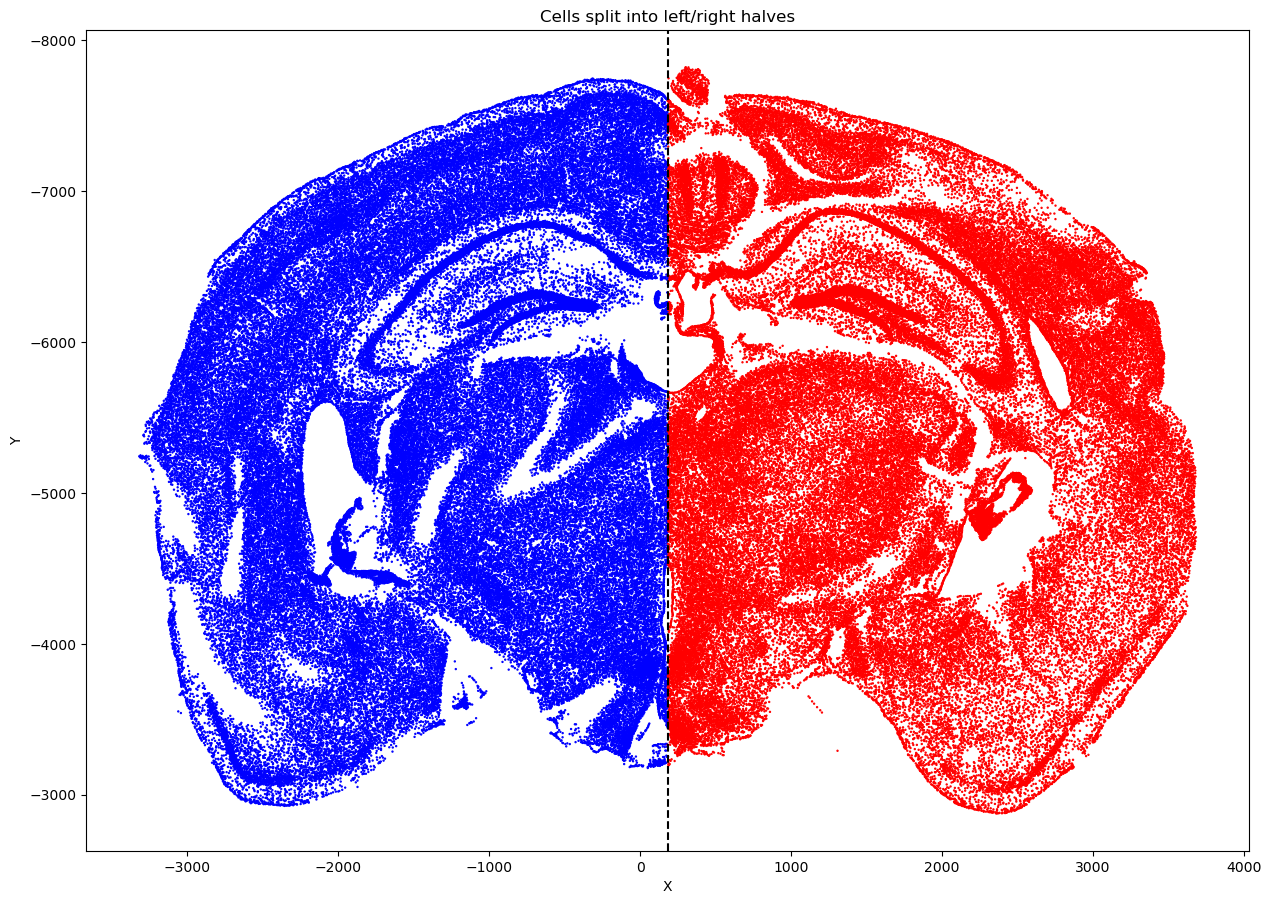

In [10]:
plt.figure(figsize=(15,15))
plt.scatter(rotated_coords[:,0], rotated_coords[:,1], 
            c=adata_ave_int.obs["half"].map({"left":"blue","right":"red"}), 
            s=0.5)
plt.axvline(x=x_center, color="black", linestyle="--")  # vertical split line
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cells split into left/right halves")
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

Log10 fit: log10(y) = 0.98·log10(x) + 0.02
R (log-scale): 0.9993, p-value = 6.489e-20


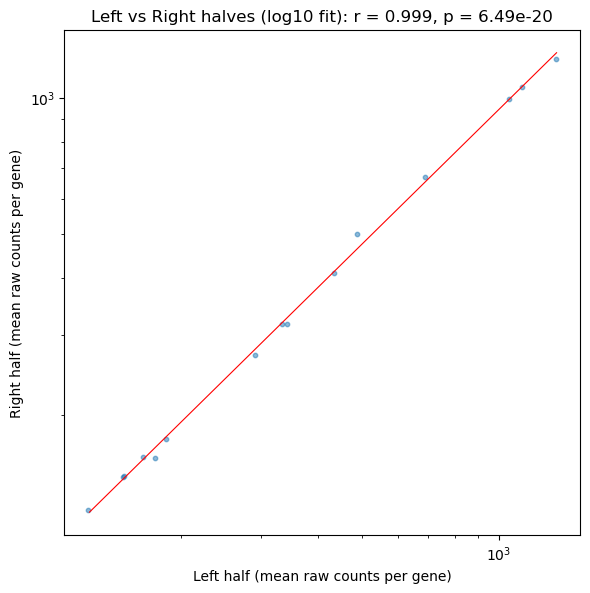

In [19]:

# -------------------------
# Data extraction
# -------------------------
left_cells = adata_ave_int.obs.index[adata_ave_int.obs["half"] == "left"]
right_cells = adata_ave_int.obs.index[adata_ave_int.obs["half"] == "right"]

X_left = adata_ave_int[left_cells, :].layers["counts"]
X_right = adata_ave_int[right_cells, :].layers["counts"]

# Convert sparse to dense
if not isinstance(X_left, np.ndarray):
    X_left = X_left.toarray()
if not isinstance(X_right, np.ndarray):
    X_right = X_right.toarray()

# Mean intensity per protein
gexp_left = np.mean(X_left, axis=0)
gexp_right = np.mean(X_right, axis=0)

# -------------------------
# Regression in log10 space
# -------------------------
log_left = np.log10(gexp_left + 1)
log_right = np.log10(gexp_right + 1)

slope, intercept, r_value, p_value, std_err = linregress(log_left, log_right)

# Build regression line (sorted)
order = np.argsort(log_left)
log_x_sorted = log_left[order]
log_y_fit_sorted = slope * log_x_sorted + intercept

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(6, 6))
plt.scatter(gexp_left, gexp_right, alpha=0.5, s=10)
plt.plot(10**log_x_sorted, 10**log_y_fit_sorted, color="red", linewidth=0.8)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Left half")
plt.ylabel("Right half")
plt.title(f"Left vs Right halves (log10 fit): r = {r_value:.3f}, p = {p_value:.2e}")

plt.gca().set_aspect("equal", adjustable="box")

print(f"Log10 fit: log10(y) = {slope:.2f}·log10(x) + {intercept:.2f}")
print(f"R (log-scale): {r_value:.4f}, p-value = {p_value:.3e}")

plt.tight_layout()
# plt.savefig("gene_correlation_left_vs_right_log.eps", format="eps")
plt.show()
plt.close()


## RNA correlation

In [24]:
# 1. Backup original coordinates
original_coords = adata_RNA.obsm["spatial"].copy()

# 2. Orient spatial coordinates
theta = np.radians(-135)
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
rotated_coords = original_coords @ rotation_matrix.T
adata_RNA.obsm["spatial_rotated"] = rotated_coords  # store in new obsm

In [26]:
# find center coordinate
x_center = (np.min(rotated_coords[:, 0]) + np.max(rotated_coords[:, 0])) / 2

# Separate into left vs right halves
left_half = rotated_coords[:, 0] <= x_center
right_half = rotated_coords[:, 0] > x_center

# Store in obs
adata_RNA.obs["half"] = np.where(right_half, "right", "left")

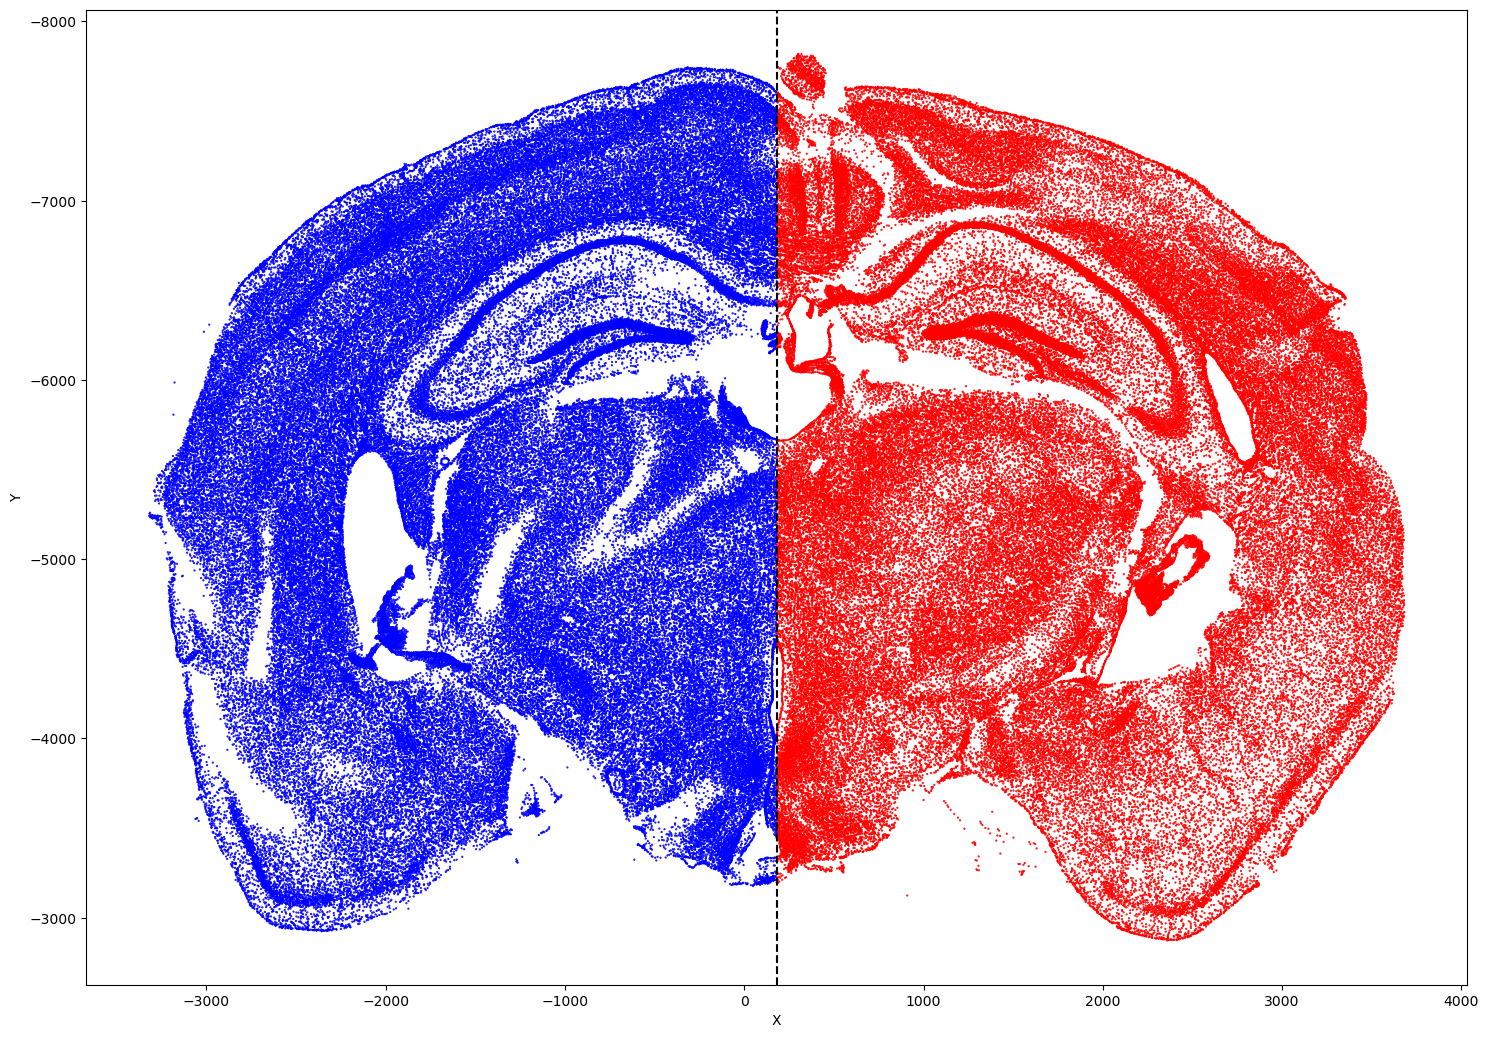

In [28]:
plt.figure(figsize=(15,15))
plt.scatter(rotated_coords[:,0], rotated_coords[:,1], 
            c=adata_RNA.obs["half"].map({"left":"blue","right":"red"}), 
            s=0.3)
plt.axvline(x=x_center, color="black", linestyle="--")  # vertical split line
plt.xlabel("X")
plt.ylabel("Y")
# plt.title("Cells split into left/right halves")
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal", adjustable="box")

plt.tight_layout()
# plt.savefig("spatial_RNA_left_vs_right.png", format="png")
plt.show()
plt.close()
# plt.show()

Left vs Right halves: r = 0.995, p = 4.42e-80


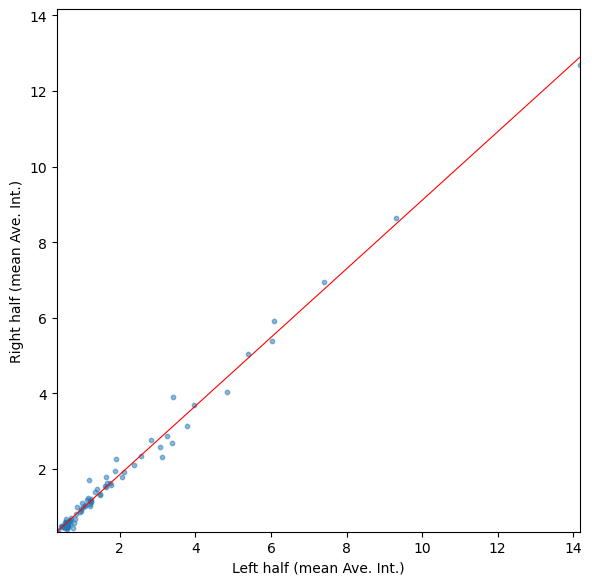

R: 0.9953671690382586 p-value: 4.4179139285378335e-80


In [34]:
# -------------------------
# Subset data
# -------------------------
left_cells = adata_RNA.obs.index[adata_RNA.obs["half"] == "left"]
right_cells = adata_RNA.obs.index[adata_RNA.obs["half"] == "right"]

X_left = adata_RNA[left_cells, :].layers["counts"]
X_right = adata_RNA[right_cells, :].layers["counts"]

# Convert sparse to dense
if not isinstance(X_left, np.ndarray):
    X_left = X_left.toarray()
if not isinstance(X_right, np.ndarray):
    X_right = X_right.toarray()

# -------------------------
# Mean expression per gene
# -------------------------
gexp_left = np.mean(X_left, axis=0)
gexp_right = np.mean(X_right, axis=0)

# -------------------------
# Linear regression
# -------------------------
slope, intercept, r_value, p_value, std_err = linregress(gexp_left, gexp_right)

# Sort for plotting regression line
order = np.argsort(gexp_left)
x_sorted = gexp_left[order]
y_fit_sorted = slope * x_sorted + intercept

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(6, 6))
plt.scatter(gexp_left, gexp_right, alpha=0.5, s=10)
plt.plot(x_sorted, y_fit_sorted, color="red", linewidth=0.8)

plt.xlabel("Left half (mean Ave. Int.)")
plt.ylabel("Right half (mean Ave. Int.)")

# Equal axis scaling
lims = [
    min(gexp_left.min(), gexp_right.min()),
    max(gexp_left.max(), gexp_right.max())
]
plt.xlim(lims)
plt.ylim(lims)
plt.gca().set_aspect('equal', adjustable='box')

print(f"Left vs Right halves: r = {r_value:.3f}, p = {p_value:.2e}")

plt.tight_layout()
# plt.savefig("gene_correlation_left_vs_right.eps", format="eps")
plt.show()
plt.close()

print("R:", r_value, "p-value:", p_value)
